In [43]:
from pathlib import Path

import numpy as np
import matplotlib.pyplot as plt
import polars as pl

from src.BrirComparison import brir_comparison
from src.SimpleSynthesis import SimpleSynthesis
from src.SdmIsmAnalysis import (
    SdmIsmAnalysis, 
    estimate_mixing_time_95,
    matlab_with_SDMtools,
    Plane
)

# SRIR Analysis

In [3]:
eng = matlab_with_SDMtools()

In [8]:
dpm = 2072 / 8.43  # dots per meter, measured in GIMP

approx_volume = 7 * 6 * 2.8
approx_mixing_time = estimate_mixing_time_95(approx_volume)


a = SdmIsmAnalysis(
    eng,
    planes=[  # going clockwise from SiL, looking from above
        Plane(4.59 - 1.04, np.array([0.0, 1.0, 0.0])),  # next to SiL
        Plane(4.07 - 0.3, np.array([1.0, 0.0, 0.0])),  # behind FC
        Plane(6.93 + 1.04 - 4.59, np.array([0.0, -1.0, 0.0])),  # behind SiR
        Plane(5.94 + 0.3 - 4.07, np.array([-1.0, 0.0, 0.0])),  # next to BC
        Plane(
            499 / dpm, np.array([-1.0, 1.0, 0.0]) / np.sqrt(2)
        ),  # diagonal, approx. 499 px from origin as measured in GIMP
        Plane(0, np.array([0.0, 0.0, -1.0])),  # floor
        Plane(
            2.8, np.array([0.0, 0.0, 1.0])
        ),  # ceiling, height in paper on page 3 ("Example Measurement")
    ],
    mixing_time=approx_mixing_time,
    HRTF_path="data/processed/RWTH-2020-11307/Kemar_HRTF_sofa-onax_normalized.sofa",
)
a.read_source_fr("../data/external/RL906-spatial-FR.sofa")

SOFA file contained custom entries
----------------------------------
GLOBAL_RoomDescription


In [9]:
room = "HL05W"

In [15]:
listener = "0.0X_0.0Y"

In [16]:
a.read_sofa(
    Path(f"../data/external/zenodo.10450779/{room}/{room}_{listener}.sofa")
)

## Source 0

In [ ]:
source = 0

a.calculate_doa(source_index=source)
a.calculate_ism()
a.quantize_doa()
a.smooth_quantized_doa()
a.calculate_extraction_metrics()
a.extract_selected()
a.render_reference_BRIRs()
a.render_diffuse_BRIRs()
a.save_result("../data/processed/example-analysis")

## Source 1

In [21]:
source = 1

a.calculate_doa(source_index=source)
a.calculate_ism()
a.quantize_doa()
a.smooth_quantized_doa()
a.calculate_extraction_metrics()
a.extract_selected()
a.render_reference_BRIRs()
a.render_diffuse_BRIRs()
a.save_result("../data/processed/example-analysis")

**Take a look at the output folder!**

# BRIR Synthesis

In [20]:
# synthesize from this one
f = (
    SimpleSynthesis()
    .read_HRTFs(
        "../data/processed/RWTH-2020-11307/Kemar_HRTF_sofa-onax_normalized.sofa"
    )
    .read_source_fr("../data/external/RL906-spatial-FR.sofa")
)

# try to match this one
t = SimpleSynthesis()

main_path = Path("../data/processed/analysis_e10_full_run2")

SOFA file contained custom entries
----------------------------------
GLOBAL_RoomDescription


C:\Users\jcmfs\Documents\MA\e4-vis-dataset\.venv\Lib\site-packages\pyfar\classes\coordinates.py:1050: PyfarDeprecationWarning: 'This function will be deprecated in pyfar 0.8.0 in favor of spharpy.samplings.SamplingSphere.'
  warnings.warn((


SOFA file contained custom entries
----------------------------------
GLOBAL_RoomDescription


In [22]:
from_source = 0
from_listener = listener

to_source = 1
to_listener=listener

In [25]:
from_name = f"{room}_{from_listener}_{from_source}SRC"
from_path = main_path / from_name
f.read_input_sofas(from_path)

SOFA file contained custom entries
----------------------------------
GLOBAL_RoomDescription, GLOBAL_ReflectionHistories, PlaneNormals, PlaneDistances, SpeedOfSound


C:\Users\jcmfs\Documents\MA\e4-vis-dataset\.venv\Lib\site-packages\pyfar\classes\coordinates.py:1050: PyfarDeprecationWarning: 'This function will be deprecated in pyfar 0.8.0 in favor of spharpy.samplings.SamplingSphere.'
  warnings.warn((


In [28]:
runs = pl.read_parquet(from_path / "runs.parquet").with_row_index()

In [30]:
filtered_imsrcs = runs.filter(pl.col("filter_energy") >= 5.5)[
    "index"
].to_list()
print(f"filtering imsrcs indices: {filtered_imsrcs} | src: {runs[filtered_imsrcs]['src'].to_list()}")

filtering imsrcs indices: [15] | src: [203]


In [31]:
to_name = f"{room}_{to_listener}_{to_source}SRC"
to_path = main_path / to_name
t.read_input_sofas(to_path)

SOFA file contained custom entries
----------------------------------
GLOBAL_RoomDescription, GLOBAL_ReflectionHistories, PlaneNormals, PlaneDistances, SpeedOfSound


In [32]:
brirs = f.extrapolating_synthesis(
            t.source_position,
            t.source_orientation,
            t.listener_position,
            ignore_imsrcs=[],
            imsrcs_make_unextrapolated=filtered_imsrcs,
        )

Text(0.5, 1.0, 'Extrapolated BRIRs')

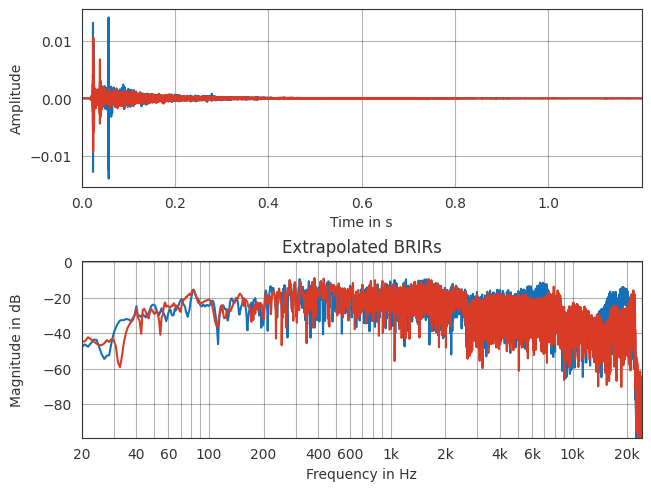

In [40]:
pf.plot.time_freq(brirs[0])
plt.title("Extrapolated BRIRs")

Text(0.5, 1.0, 'Extrapolated BRIRs')

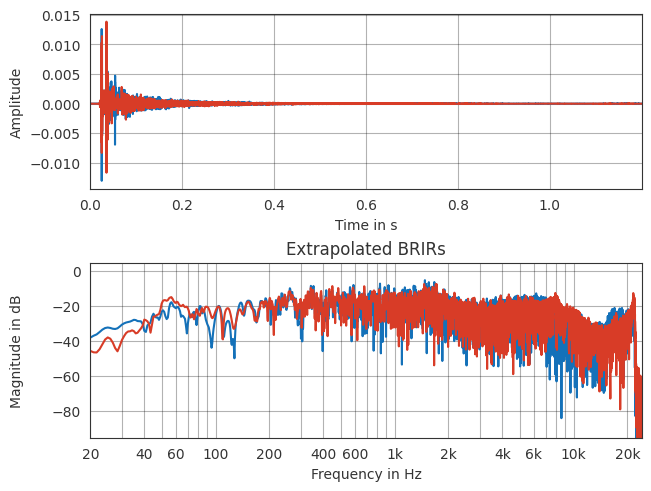

In [41]:
pf.plot.time_freq(t.reference_brirs[0])
plt.title("Extrapolated BRIRs")

# Objective BRIR Comparison

In [42]:
brir_comparison(t.reference_brirs, brirs)

{'rmse': 2.7180963781809058,
 'lag': -62.833333333333336,
 'lag_std': 338.4406233825301,
 'lag_rms': 344.2238854776544,
 'xcorr': 0.45671854644051235,
 'xcorr_std': 0.22725301554932176,
 'level_delta': -0.88454878221151,
 'level_rms': 2.4488722897993522,
 'misdistributed_energy': 0.2781813944217357,
 't30_rel_delta': 0.006535980939339429,
 't30_rel_rms': 0.03511592484821129,
 'c20_delta': -2.2739148478184004,
 'c20_rms': 4.344752066626433,
 'iacc_delta': 0.05466963974481296,
 'iacc_rms': 0.0936658254363371,
 'lag_iacc_delta': 0.25,
 'lag_iacc_rms': 0.5,
 'ild_delta': 0.08250120651687577,
 'ild_rms': 3.706415832859833,
 'spectral_difference': 0.3433605744871551}